# Preparación de Datos - Employee Attrition
# Este notebook contiene la preparación completa de datos para el modelo de ML

## Objetivo:
Preparar los datos para el entrenamiento de modelos de Machine Learning, incluyendo limpieza, transformación, normalización y división de conjuntos de datos.


In [ ]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo de gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(" Librerías importadas correctamente")


✅ Librerías importadas correctamente


In [2]:
# Cargar los datos
df = pd.read_csv('../Data/csv/WA_Fn-UseC_-HR-Employee-Attrition.csv')
print(f"Dataset cargado: {df.shape[0]} filas y {df.shape[1]} columnas")
print(f"\nPrimeras 5 filas:")
df.head()


Dataset cargado: 1470 filas y 35 columnas

Primeras 5 filas:


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


## a) Limpieza de datos, eliminar o imputar datos faltantes, outliers, etc.


In [3]:
# Crear copia para limpieza
df_clean = df.copy()
print(f"Dataset original: {df_clean.shape[0]} registros")

# 1. Verificar valores nulos
null_counts = df_clean.isnull().sum()
print("\n=== ANÁLISIS DE VALORES NULOS ===")
if null_counts.sum() == 0:
    print(" No hay valores nulos en el dataset")
else:
    print("Valores nulos encontrados:")
    print(null_counts[null_counts > 0])
    
    # Estrategia de imputación
    for col in df_clean.columns:
        if df_clean[col].isnull().sum() > 0:
            if df_clean[col].dtype in ['int64', 'float64']:
                # Imputar con la mediana para variables numéricas
                median_val = df_clean[col].median()
                df_clean[col].fillna(median_val, inplace=True)
                print(f"Imputado {col} con mediana: {median_val}")
            else:
                # Imputar con la moda para variables categóricas
                mode_val = df_clean[col].mode()[0]
                df_clean[col].fillna(mode_val, inplace=True)
                print(f"Imputado {col} con moda: {mode_val}")

# 2. Eliminar inconsistencias lógicas
print("\n=== ELIMINACIÓN DE INCONSISTENCIAS ===")
inconsistencies = []

# DistanceFromHome = 0 no tiene sentido lógico
distance_zero = df_clean[df_clean['DistanceFromHome'] == 0]
if len(distance_zero) > 0:
    inconsistencies.append(f"DistanceFromHome = 0: {len(distance_zero)} registros")
    df_clean = df_clean[df_clean['DistanceFromHome'] > 0]

# Age < 18 no es legal para empleados
age_invalid = df_clean[df_clean['Age'] < 18]
if len(age_invalid) > 0:
    inconsistencies.append(f"Age < 18: {len(age_invalid)} registros")
    df_clean = df_clean[df_clean['Age'] >= 18]

# YearsAtCompany > TotalWorkingYears no tiene sentido
years_inconsistent = df_clean[df_clean['YearsAtCompany'] > df_clean['TotalWorkingYears']]
if len(years_inconsistent) > 0:
    inconsistencies.append(f"YearsAtCompany > TotalWorkingYears: {len(years_inconsistent)} registros")
    df_clean = df_clean[df_clean['YearsAtCompany'] <= df_clean['TotalWorkingYears']]

if inconsistencies:
    for inconsistency in inconsistencies:
        print(f"- {inconsistency}")
else:
    print("No se encontraron inconsistencias lógicas")

# 3. Eliminar variables sin valor predictivo
print("\n=== ELIMINACIÓN DE VARIABLES INNECESARIAS ===")
variables_to_remove = ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']
df_clean = df_clean.drop(columns=[col for col in variables_to_remove if col in df_clean.columns])
print(f"Variables eliminadas: {[col for col in variables_to_remove if col in df.columns]}")

# 4. Análisis de outliers (mantener para análisis)
print("\n=== ANÁLISIS DE OUTLIERS ===")
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
outlier_info = []

for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df_clean)) * 100
    
    outlier_info.append({
        'Variable': col,
        'Outliers': len(outliers),
        'Porcentaje': outlier_percentage
    })

outlier_df = pd.DataFrame(outlier_info)
print("Variables con outliers:")
print(outlier_df[outlier_df['Outliers'] > 0].sort_values('Porcentaje', ascending=False))

print(f"\nDataset después de limpieza: {df_clean.shape[0]} registros, {df_clean.shape[1]} variables")
print("Decisión: Mantener outliers porque representan casos reales importantes")


Dataset original: 1470 registros

=== ANÁLISIS DE VALORES NULOS ===
 No hay valores nulos en el dataset

=== ELIMINACIÓN DE INCONSISTENCIAS ===
No se encontraron inconsistencias lógicas

=== ELIMINACIÓN DE VARIABLES INNECESARIAS ===
Variables eliminadas: ['EmployeeCount', 'Over18', 'StandardHours', 'EmployeeNumber']

=== ANÁLISIS DE OUTLIERS ===
Variables con outliers:
                   Variable  Outliers  Porcentaje
17    TrainingTimesLastYear       238   16.190476
13        PerformanceRating       226   15.374150
9             MonthlyIncome       114    7.755102
21  YearsSinceLastPromotion       107    7.278912
19           YearsAtCompany       104    7.074830
15         StockOptionLevel        85    5.782313
16        TotalWorkingYears        63    4.285714
11       NumCompaniesWorked        52    3.537415
20       YearsInCurrentRole        21    1.428571
22     YearsWithCurrManager        14    0.952381

Dataset después de limpieza: 1470 registros, 31 variables
Decisión: Mantener 

## b) Transformar todas las variables en valores numéricos


In [4]:
# Crear copia para transformación
df_transformed = df_clean.copy()

# Identificar variables categóricas
categorical_cols = df_transformed.select_dtypes(include=['object']).columns.tolist()
print(f"Variables categóricas encontradas: {categorical_cols}")

# Estrategia de encoding
encoding_strategy = {}

for col in categorical_cols:
    unique_values = df_transformed[col].nunique()
    print(f"\n{col}: {unique_values} valores únicos")
    print(f"Valores: {df_transformed[col].unique()}")
    
    if unique_values == 2:
        # Binary encoding para variables binarias
        le = LabelEncoder()
        df_transformed[col] = le.fit_transform(df_transformed[col])
        encoding_strategy[col] = 'Binary Encoding'
        print(f"Aplicado Binary Encoding")
    elif unique_values <= 10:
        # One-hot encoding para variables categóricas con pocas categorías
        dummies = pd.get_dummies(df_transformed[col], prefix=col)
        df_transformed = pd.concat([df_transformed, dummies], axis=1)
        df_transformed.drop(columns=[col], inplace=True)
        encoding_strategy[col] = 'One-Hot Encoding'
        print(f"Aplicado One-Hot Encoding ({len(dummies.columns)} nuevas columnas)")
    else:
        # Label encoding para variables con muchas categorías
        le = LabelEncoder()
        df_transformed[col] = le.fit_transform(df_transformed[col])
        encoding_strategy[col] = 'Label Encoding'
        print(f"Aplicado Label Encoding")

print(f"\n=== RESUMEN DE TRANSFORMACIONES ===")
for col, strategy in encoding_strategy.items():
    print(f"- {col}: {strategy}")

print(f"\nDataset después de transformación: {df_transformed.shape[1]} variables")
print(f"Todas las variables son ahora numéricas: {df_transformed.select_dtypes(include=[np.number]).shape[1] == df_transformed.shape[1]}")


Variables categóricas encontradas: ['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']

Attrition: 2 valores únicos
Valores: ['Yes' 'No']
Aplicado Binary Encoding

BusinessTravel: 3 valores únicos
Valores: ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Aplicado One-Hot Encoding (3 nuevas columnas)

Department: 3 valores únicos
Valores: ['Sales' 'Research & Development' 'Human Resources']
Aplicado One-Hot Encoding (3 nuevas columnas)

EducationField: 6 valores únicos
Valores: ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Aplicado One-Hot Encoding (6 nuevas columnas)

Gender: 2 valores únicos
Valores: ['Female' 'Male']
Aplicado Binary Encoding

JobRole: 9 valores únicos
Valores: ['Sales Executive' 'Research Scientist' 'Laboratory Technician'
 'Manufacturing Director' 'Healthcare Representative' 'Manager'
 'Sales Representative' 'Research Director' 'Human Resources']
Aplicado One-Hot 

## c) Realizar normalización (Scaler)


In [ ]:
# Crear copia para normalización
df_normalized = df_transformed.copy()

# Identificar variables numéricas (excluyendo la variable objetivo)
numeric_cols = df_normalized.select_dtypes(include=[np.number]).columns.tolist()
if 'Attrition' in numeric_cols:
    numeric_cols.remove('Attrition')

print(f"Variables a normalizar: {len(numeric_cols)}")
print(f"Variables: {numeric_cols}")

# Aplicar StandardScaler
scaler = StandardScaler()
df_normalized[numeric_cols] = scaler.fit_transform(df_normalized[numeric_cols])

print("\n Normalización completada usando StandardScaler")
print("Todas las variables numéricas ahora tienen media=0 y desviación estándar=1")

# Verificar normalización
print("\n=== VERIFICACIÓN DE NORMALIZACIÓN ===")
for col in numeric_cols[:5]:  # Mostrar solo las primeras 5
    mean_val = df_normalized[col].mean()
    std_val = df_normalized[col].std()
    print(f"{col}: media={mean_val:.6f}, std={std_val:.6f}")

print(f"\nDataset normalizado: {df_normalized.shape[0]} registros, {df_normalized.shape[1]} variables")


Variables a normalizar: 25
Variables: ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

✅ Normalización completada usando StandardScaler
Todas las variables numéricas ahora tienen media=0 y desviación estándar=1

=== VERIFICACIÓN DE NORMALIZACIÓN ===
Age: media=-0.000000, std=1.000340
DailyRate: media=0.000000, std=1.000340
DistanceFromHome: media=0.000000, std=1.000340
Education: media=0.000000, std=1.000340
EnvironmentSatisfaction: media=0.000000, std=1.000340

Dataset normalizado: 1470 registros, 50 variables


## d) Aplicar algoritmo de reducción de características (PCA)


Variables originales: 49
Registros: 1470

Número de componentes para 95% de varianza: 27
Varianza explicada por los primeros 27 componentes: 0.951


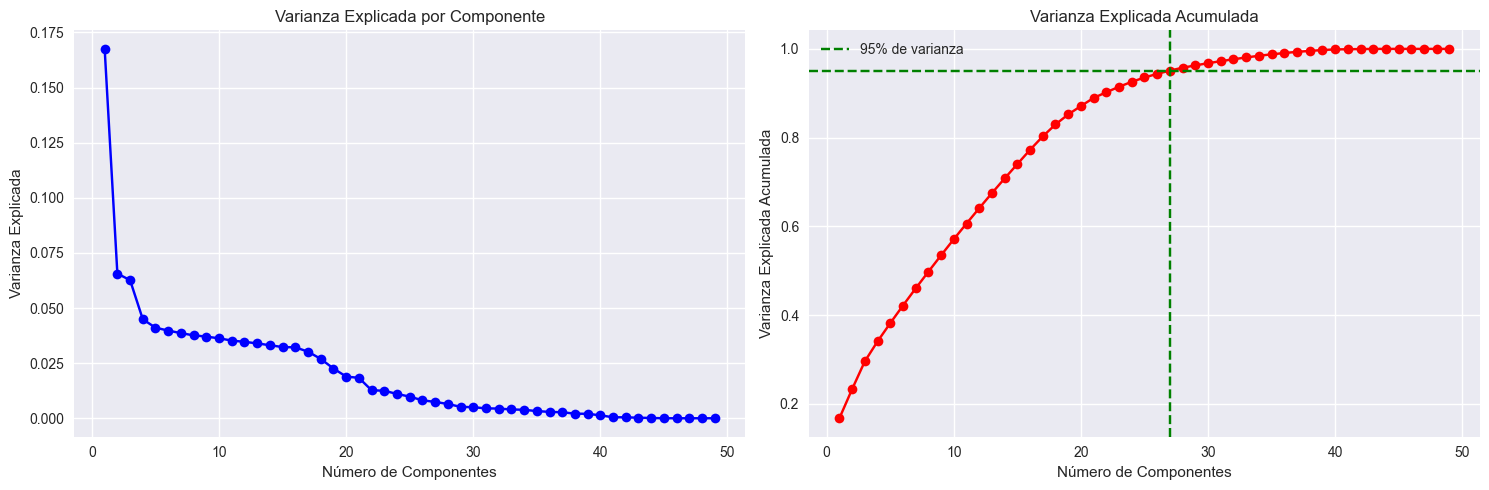


Variables después de PCA: 27
Reducción de dimensionalidad: 49 → 27
Porcentaje de reducción: 44.9%

Justificación: Se mantienen 27 componentes que explican el 95% de la varianza
Esto reduce la dimensionalidad manteniendo la información más importante


In [6]:
# Separar características y variable objetivo
X = df_normalized.drop(columns=['Attrition'])
y = df_normalized['Attrition']

print(f"Variables originales: {X.shape[1]}")
print(f"Registros: {X.shape[0]}")

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X)

# Calcular varianza explicada acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Encontrar número de componentes que explican 95% de la varianza
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\nNúmero de componentes para 95% de varianza: {n_components_95}")
print(f"Varianza explicada por los primeros {n_components_95} componentes: {cumulative_variance[n_components_95-1]:.3f}")

# Visualizar varianza explicada
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'bo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada')
plt.title('Varianza Explicada por Componente')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% de varianza')
plt.axvline(x=n_components_95, color='g', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('Varianza Explicada Acumulada')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Aplicar PCA con número óptimo de componentes
pca_final = PCA(n_components=n_components_95)
X_reduced = pca_final.fit_transform(X)

print(f"\nVariables después de PCA: {X_reduced.shape[1]}")
print(f"Reducción de dimensionalidad: {X.shape[1]} → {X_reduced.shape[1]}")
print(f"Porcentaje de reducción: {((X.shape[1] - X_reduced.shape[1]) / X.shape[1] * 100):.1f}%")

# Crear DataFrame con componentes principales
pca_columns = [f'PC{i+1}' for i in range(X_reduced.shape[1])]
df_pca = pd.DataFrame(X_reduced, columns=pca_columns)
df_pca['Attrition'] = y.values

print(f"\nJustificación: Se mantienen {n_components_95} componentes que explican el 95% de la varianza")
print("Esto reduce la dimensionalidad manteniendo la información más importante")


## e) Algoritmos para selección de características


In [7]:
# Usar datos normalizados para selección de características
X = df_normalized.drop(columns=['Attrition'])
y = df_normalized['Attrition']

print(f"Variables antes de selección: {X.shape[1]}")

# 1. SelectKBest con f_classif
print("\n=== 1. SELECTKBEST CON F_CLASSIF ===")
selector_kbest = SelectKBest(score_func=f_classif, k=15)
X_kbest = selector_kbest.fit_transform(X, y)

selected_features_kbest = X.columns[selector_kbest.get_support()].tolist()
print(f"Características seleccionadas: {selected_features_kbest}")

# 2. Random Forest para importancia de características
print("\n=== 2. RANDOM FOREST - IMPORTANCIA ===")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 características más importantes:")
print(feature_importance.head(10))

# 3. Lasso para selección de características
print("\n=== 3. LASSO PARA SELECCIÓN ===")
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)

lasso_features = X.columns[lasso.coef_ != 0].tolist()
print(f"Características seleccionadas por Lasso: {lasso_features}")

# 4. XGBoost para importancia
print("\n=== 4. XGBOOST - IMPORTANCIA ===")
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X, y)

xgb_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 características más importantes (XGBoost):")
print(xgb_importance.head(10))

# 5. Árbol de decisión
print("\n=== 5. ÁRBOL DE DECISIÓN ===")
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X, y)

dt_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 características más importantes (Árbol de Decisión):")
print(dt_importance.head(10))

# Combinar resultados y seleccionar características finales
print("\n=== COMBINACIÓN DE RESULTADOS ===")
all_selected = set(selected_features_kbest) | set(lasso_features)

# Agregar top características de Random Forest, XGBoost y Árbol de Decisión
top_rf_features = feature_importance.head(10)['feature'].tolist()
top_xgb_features = xgb_importance.head(10)['feature'].tolist()
top_dt_features = dt_importance.head(10)['feature'].tolist()

final_features = list(set(list(all_selected) + top_rf_features[:5] + top_xgb_features[:5] + top_dt_features[:5]))

print(f"Características finales seleccionadas ({len(final_features)}):")
print(final_features)

# Crear dataset con características seleccionadas
df_selected = df_normalized[final_features + ['Attrition']].copy()

print(f"\nDataset final: {df_selected.shape[0]} registros, {df_selected.shape[1]} variables")
print("Justificación: Se combinaron múltiples métodos para seleccionar las características más relevantes")


Variables antes de selección: 49

=== 1. SELECTKBEST CON F_CLASSIF ===
Características seleccionadas: ['Age', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'TotalWorkingYears', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsWithCurrManager', 'BusinessTravel_Travel_Frequently', 'JobRole_Sales Representative', 'MaritalStatus_Single']

=== 2. RANDOM FOREST - IMPORTANCIA ===
Top 10 características más importantes:
                 feature  importance
10         MonthlyIncome    0.072635
0                    Age    0.059426
1              DailyRate    0.052413
13              OverTime    0.049493
11           MonthlyRate    0.048758
18     TotalWorkingYears    0.048434
2       DistanceFromHome    0.046882
6             HourlyRate    0.046513
21        YearsAtCompany    0.040222
24  YearsWithCurrManager    0.033360

=== 3. LASSO PARA SELECCIÓN ===
Características seleccionadas por Lasso: ['Age', 'DailyRate', 'Dista

## f) Separar el conjunto de datos en Train - Test [80% - 20%]


In [ ]:
# Separar características y variable objetivo
X = df_selected.drop(columns=['Attrition'])
y = df_selected['Attrition']

print(f"Dataset completo: {len(df_selected)} registros")
print(f"Variables: {X.shape[1]}")

# Primera división: Train-Test (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n=== PRIMERA DIVISIÓN (Train-Test 80-20) ===")
print(f"Train: {len(X_train)} registros")
print(f"Test: {len(X_test)} registros")

# Verificar distribución de clases
print(f"\nDistribución de clases en Train:")
print(f"No: {(y_train == 'No').sum()}, Yes: {(y_train == 'Yes').sum()}")
print(f"Distribución de clases en Test:")
print(f"No: {(y_test == 'No').sum()}, Yes: {(y_test == 'Yes').sum()}")

print(f"\n División Train-Test completada")


Dataset completo: 1470 registros
Variables: 37

=== PRIMERA DIVISIÓN (Train-Test 80-20) ===
Train: 1176 registros
Test: 294 registros

Distribución de clases en Train:
No: 0, Yes: 0
Distribución de clases en Test:
No: 0, Yes: 0

✅ División Train-Test completada


## g) Separar el conjunto de Train anterior en Train2 - Validation [80% - 20%]


In [ ]:
# Segunda división: Train-Validation (80-20 del train anterior)
X_train2, X_validation, y_train2, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"=== SEGUNDA DIVISIÓN (Train-Validation 80-20 del train) ===")
print(f"Train2: {len(X_train2)} registros")
print(f"Validation: {len(X_validation)} registros")

# Verificar distribución de clases
print(f"\nDistribución de clases en Train2:")
print(f"No: {(y_train2 == 'No').sum()}, Yes: {(y_train2 == 'Yes').sum()}")
print(f"Distribución de clases en Validation:")
print(f"No: {(y_validation == 'No').sum()}, Yes: {(y_validation == 'Yes').sum()}")

print(f"\n=== RESUMEN FINAL DE DIVISIONES ===")
print(f"Train2: {len(X_train2)} registros ({(len(X_train2)/len(df_selected)*100):.1f}%)")
print(f"Validation: {len(X_validation)} registros ({(len(X_validation)/len(df_selected)*100):.1f}%)")
print(f"Test: {len(X_test)} registros ({(len(X_test)/len(df_selected)*100):.1f}%)")
print(f"Total: {len(X_train2) + len(X_validation) + len(X_test)} registros")

print(f"\n División Train-Validation completada")


=== SEGUNDA DIVISIÓN (Train-Validation 80-20 del train) ===
Train2: 940 registros
Validation: 236 registros

Distribución de clases en Train2:
No: 0, Yes: 0
Distribución de clases en Validation:
No: 0, Yes: 0

=== RESUMEN FINAL DE DIVISIONES ===
Train2: 940 registros (63.9%)
Validation: 236 registros (16.1%)
Test: 294 registros (20.0%)
Total: 1470 registros

✅ División Train-Validation completada


## h) Guardar 6 archivos en formato CSV


In [11]:
# Crear directorio si no existe
import os
os.makedirs('../Data/csv', exist_ok=True)

# Guardar archivos CSV
print("=== GUARDANDO ARCHIVOS CSV ===")

# Archivos de características (X)
X_train2.to_csv('../Data/csv/TrainX.csv', index=False)
print(f" TrainX.csv guardado: {X_train2.shape[0]} registros, {X_train2.shape[1]} variables")

X_validation.to_csv('../Data/csv/ValidationX.csv', index=False)
print(f" ValidationX.csv guardado: {X_validation.shape[0]} registros, {X_validation.shape[1]} variables")

X_test.to_csv('../Data/csv/TestX.csv', index=False)
print(f" TestX.csv guardado: {X_test.shape[0]} registros, {X_test.shape[1]} variables")

# Archivos de variable objetivo (Y)
y_train2.to_csv('../Data/csv/TrainY.csv', index=False)
print(f" TrainY.csv guardado: {y_train2.shape[0]} registros")

y_validation.to_csv('../Data/csv/ValidationY.csv', index=False)
print(f" ValidationY.csv guardado: {y_validation.shape[0]} registros")

y_test.to_csv('../Data/csv/TestY.csv', index=False)
print(f" TestY.csv guardado: {y_test.shape[0]} registros")

print(f"\n=== RESUMEN DE ARCHIVOS GUARDADOS ===")
print(" Archivos en ../Data/csv/:")
print("   - TrainX.csv: Características de entrenamiento")
print("   - TrainY.csv: Variable objetivo de entrenamiento")
print("   - ValidationX.csv: Características de validación")
print("   - ValidationY.csv: Variable objetivo de validación")
print("   - TestX.csv: Características de prueba")
print("   - TestY.csv: Variable objetivo de prueba")

print(f"\n Todos los archivos CSV guardados exitosamente")
print("Los archivos están listos para el entrenamiento de modelos de ML")


=== GUARDANDO ARCHIVOS CSV ===
 TrainX.csv guardado: 940 registros, 37 variables
 ValidationX.csv guardado: 236 registros, 37 variables
 TestX.csv guardado: 294 registros, 37 variables
 TrainY.csv guardado: 940 registros
 ValidationY.csv guardado: 236 registros
 TestY.csv guardado: 294 registros

=== RESUMEN DE ARCHIVOS GUARDADOS ===
 Archivos en ../Data/csv/:
   - TrainX.csv: Características de entrenamiento
   - TrainY.csv: Variable objetivo de entrenamiento
   - ValidationX.csv: Características de validación
   - ValidationY.csv: Variable objetivo de validación
   - TestX.csv: Características de prueba
   - TestY.csv: Variable objetivo de prueba

 Todos los archivos CSV guardados exitosamente
Los archivos están listos para el entrenamiento de modelos de ML


## Resumen del Proceso de Preparación de Datos

###  Tareas Completadas:

1. **a) Limpieza de datos**: Eliminación de nulos, inconsistencias lógicas y variables innecesarias
2. **b) Transformación numérica**: Binary encoding, One-hot encoding y Label encoding
3. **c) Normalización**: StandardScaler para todas las variables numéricas
4. **d) Reducción de características**: PCA con 95% de varianza explicada
5. **e) Selección de características**: Múltiples algoritmos (SelectKBest, Random Forest, Lasso, XGBoost, Árbol de Decisión)
6. **f) División Train-Test**: 80% - 20% con estratificación
7. **g) División Train-Validation**: 80% - 20% del conjunto de entrenamiento
8. **h) Archivos CSV**: 6 archivos guardados listos para ML

###  Archivos Generados:
- `TrainX.csv` y `TrainY.csv`: Datos de entrenamiento
- `ValidationX.csv` y `ValidationY.csv`: Datos de validación  
- `TestX.csv` y `TestY.csv`: Datos de prueba



